# Time Series Modeling Energy Demand
### Brainstation Capstone Project
#### Adele DuBay 
#### Sept 27, 2021

In this notebook we'll do some exploratory data analysis on a cleaned dataset that originated from the Hourly Load Data from the Electric Reliability Council of Texas (ERCOT) Archives [website](http://www.ercot.com/gridinfo/load/load_hist/index.html). This data contains information on the hourly energy load, measured in MW, from 2008-2019 for the eight regions that make up the electric grid monitored by the ERCOT. The grid monitored by ERCOT covers almost all of Texas. 
\
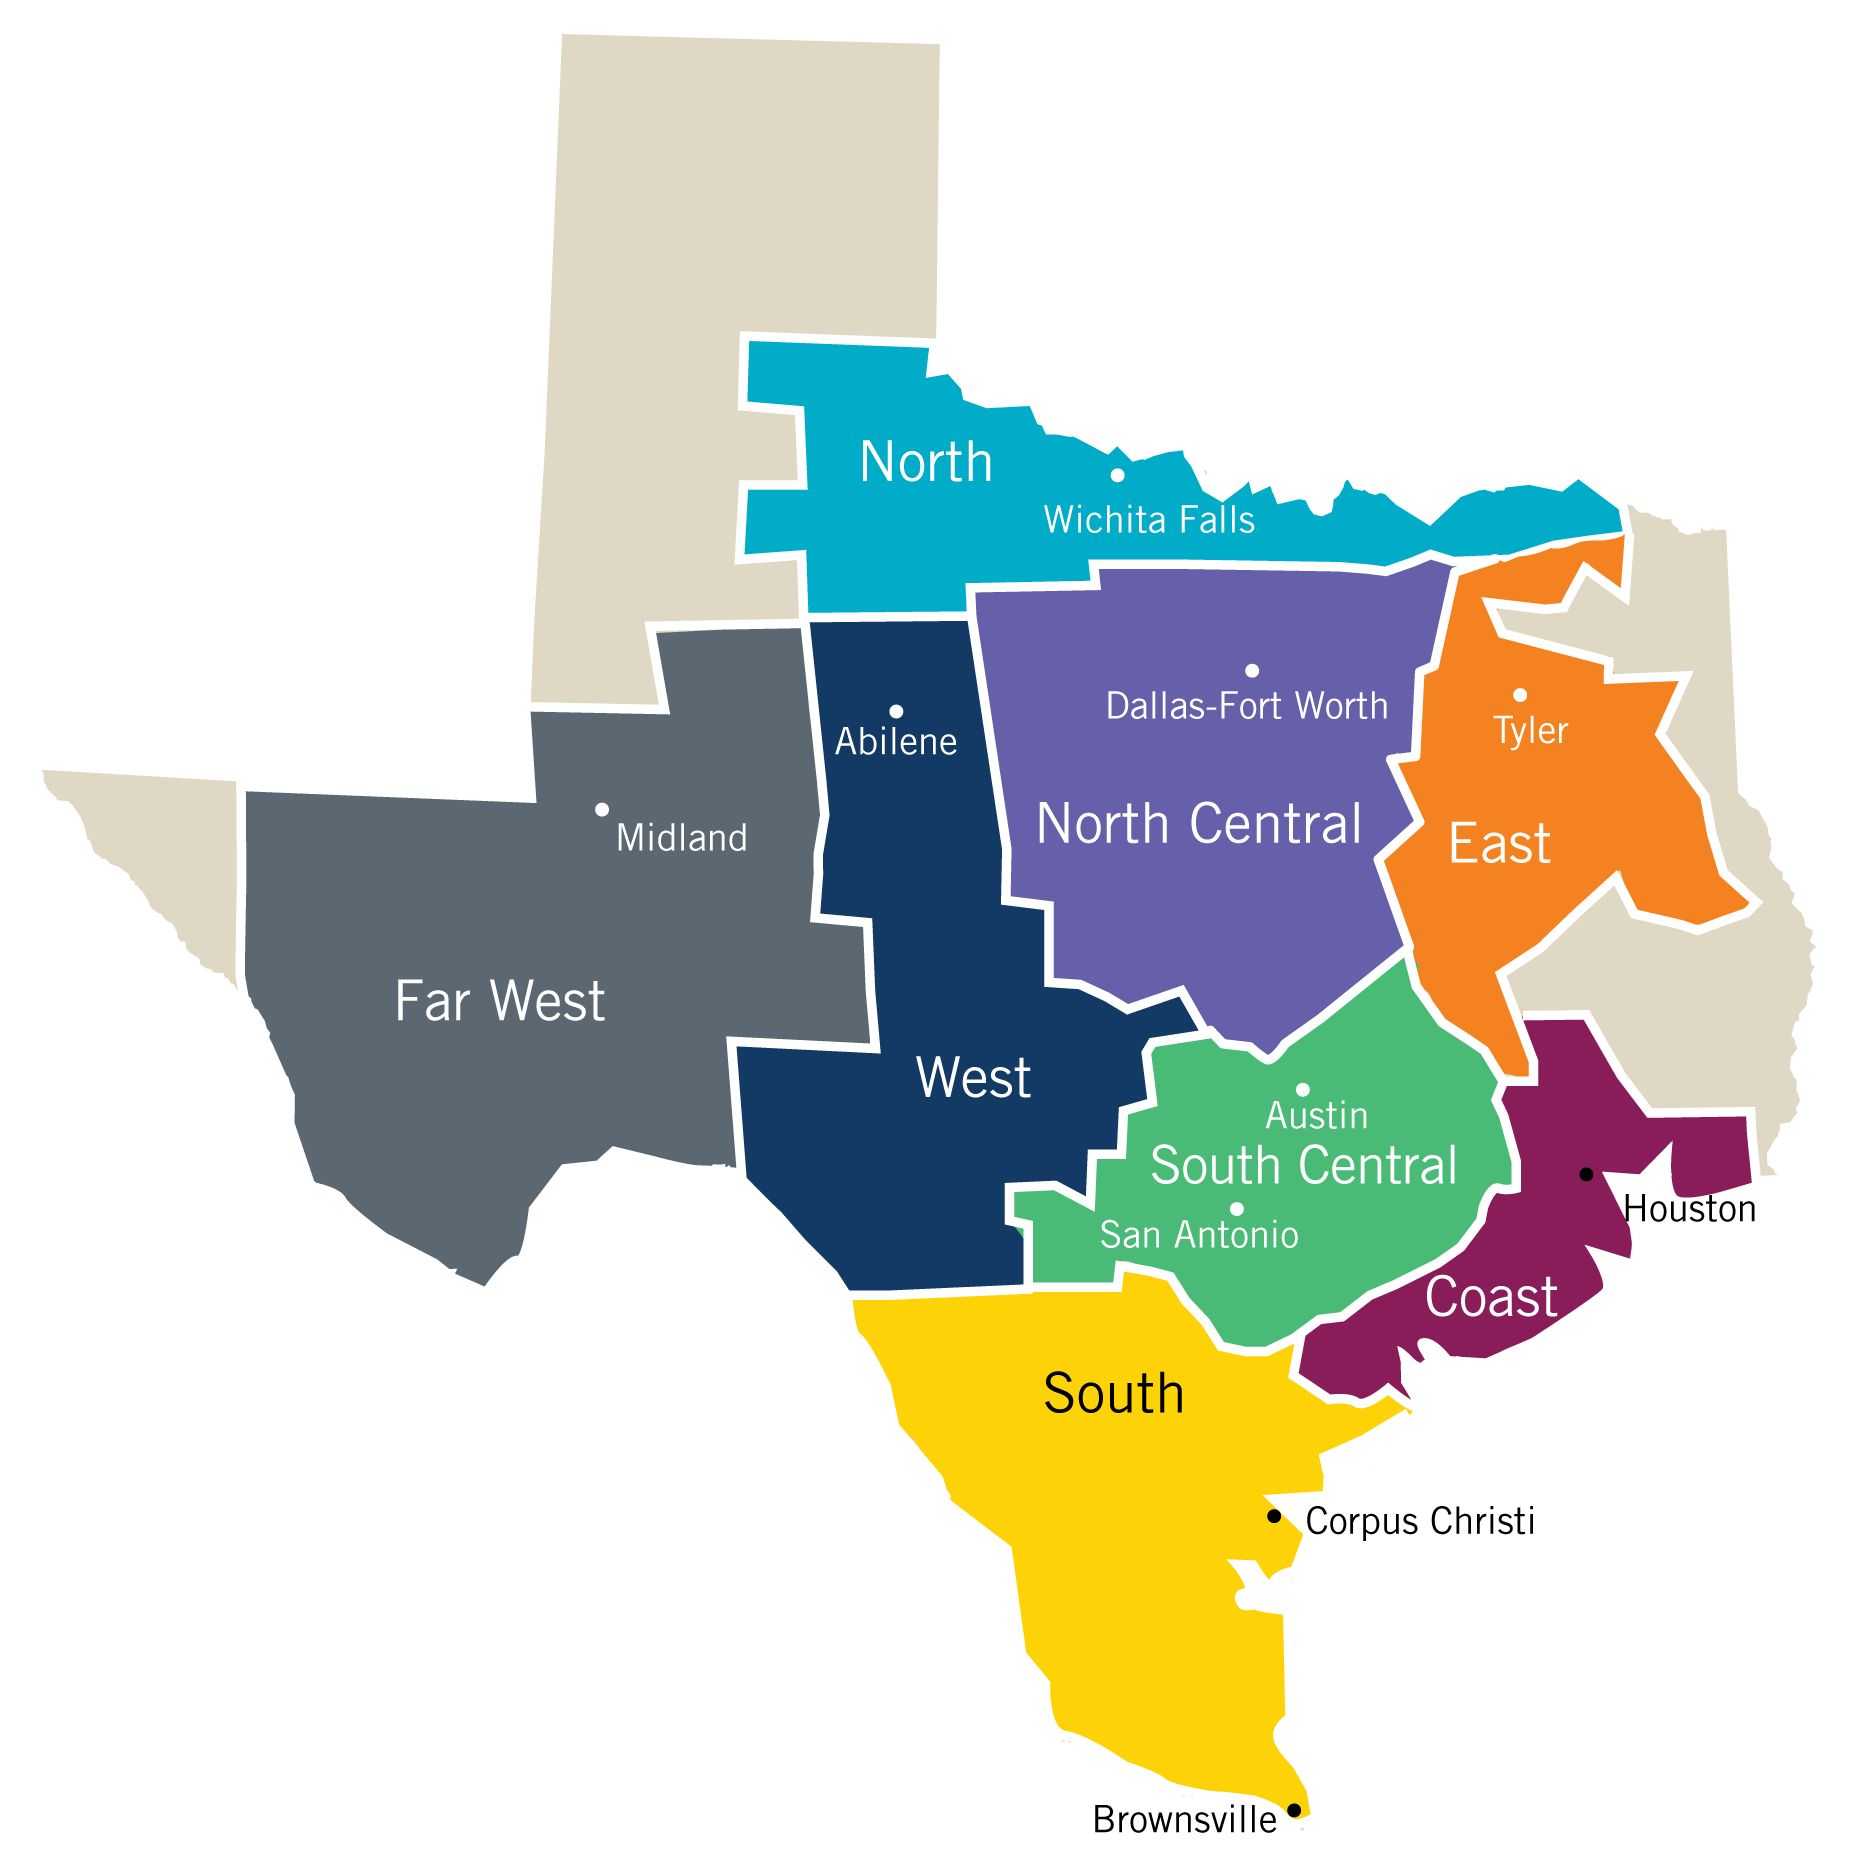
\
Let's begin by loading the `ercot_2008_2019.csv` dataset and do some exploratory data analysis. After importing the libraries and used for this process, we'll load in the data and add a few features such as `month`, `is_summer`, `day_of_week`, `is_weekday`, and `hour` and also convert the `hour` column to a datetime data type.

In [30]:
#Holy Trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Graphing
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

#Modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
#from math import sqrt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [2]:
#Read in csv and store as a dataframe
ercot_df = pd.read_csv('capstone_data/ercot_2008_2019.csv')

#Convert 'hour_end' to datetime
ercot_df['hour_end'] = pd.to_datetime(ercot_df['hour_end'])

#Drop if exists
#ercot_df.drop(['month', 'is_summer', 'day_of_week', 'is_weekday', 'hour'], axis = 1, inplace = True);

#Insert 'month' identifier column
ercot_df.insert(1, 'month', ercot_df['hour_end'].dt.month)

#Insert `is_summer` identifier column
ercot_df.insert(2, 'is_summer', ercot_df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0))

#Insert 'day_of_week' indentifier column
#NOTE: Monday = 0, Sunday = 6
ercot_df.insert(3, 'day_of_week', ercot_df['hour_end'].dt.dayofweek)

#Insert `is_weekday` identifier column, weekend days are 5, 6
ercot_df.insert(4, 'is_weekday', np.where(ercot_df["day_of_week"] == (5 or 6), 0, 1))

#Insert 'hour' indentifier column
ercot_df.insert(5, 'hour', ercot_df['hour_end'].dt.hour)
ercot_df

hour_end  month  is_summer  day_of_week  is_weekday  hour  \
0      2008-01-01 01:00:00      1          0            1           1     1   
1      2008-01-01 02:00:00      1          0            1           1     2   
2      2008-01-01 03:00:00      1          0            1           1     3   
3      2008-01-01 04:00:00      1          0            1           1     4   
4      2008-01-01 05:00:00      1          0            1           1     5   
...                    ...    ...        ...          ...         ...   ...   
105186 2019-12-31 19:00:00     12          0            1           1    19   
105187 2019-12-31 20:00:00     12          0            1           1    20   
105188 2019-12-31 21:00:00     12          0            1           1    21   
105189 2019-12-31 22:00:00     12          0            1           1    22   
105190 2019-12-31 23:00:00     12          0            1           1    23   

               coast         east     far_west        north      north_c  \
0        7582.426275  1137.197278  1289.741591  1120.591245  10782.48780   
1        7483.387277  1129.312429  1320.549720  1130.163920  10873.00119   
2        7381.744778  1155.484647  1328.442079  1129.355056  10952.63748   
3        7452.871868  1209.918355  1344.322369  1148.919804  11104.17876   
4        7530.354017  1265.055389  1355.020035  1171.267839  11369.93504   
...              ...          ...          ...          ...          ...   
105186  11326.000000  1416.720000  3624.610000   829.980000  13305.30000   
105187  11109.260000  1417.310000  3637.460000   825.760000  13164.66000   
105188  10846.500000  1411.760000  3639.020000   822.190000  12928.91000   
105189  10592.540000  1403.990000  3639.460000   819.390000  12716.27000   
105190  10304.620000  1387.050000  3630.180000   804.710000  12413.09000   

           southern      south_c         west        ercot  
0       1894.920943  4857.044340   932.251506  29596.66098  
1       1826.089194  4867.512567   939.958255  29569.97455  
2       1832.883827  4849.639885   951.322118  29581.50987  
3       1819.248340  4858.047321   967.450488  29904.95730  
4       1834.777369  4962.345559   996.055206  30484.81045  
...             ...          ...          ...          ...  
105186  3311.250000  6692.980000  1306.140000  41812.98000  
105187  3181.360000  6453.700000  1290.260000  41079.76000  
105188  3044.650000  6175.760000  1276.750000  40145.54000  
105189  2930.560000  5968.290000  1260.090000  39330.60000  
105190  2829.530000  5769.750000  1238.410000  38377.36000  

[105191 rows x 15 columns]

In [3]:
ercot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105191 entries, 0 to 105190
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   hour_end     105191 non-null  datetime64[ns]
 1   month        105191 non-null  int64         
 2   is_summer    105191 non-null  int64         
 3   day_of_week  105191 non-null  int64         
 4   is_weekday   105191 non-null  int32         
 5   hour         105191 non-null  int64         
 6   coast        105191 non-null  float64       
 7   east         105191 non-null  float64       
 8   far_west     105191 non-null  float64       
 9   north        105191 non-null  float64       
 10  north_c      105191 non-null  float64       
 11  southern     105191 non-null  float64       
 12  south_c      105191 non-null  float64       
 13  west         105191 non-null  float64       
 14  ercot        105191 non-null  float64       
dtypes: datetime64[ns](1), float64(9), 

We see that this dataset consists of:
- 105,191 rows with 15 columns (5 of which were just added when loading the data)
- Column of time and date by the hour, `hour_end`
- Data recording the energy demand (in MegaWatts MW) across the 8 different regions that make up the entire grid monitored by ERCOT
- Column with the hour total, `ercot`.  

From this we can create a dataframe where the index is the `hour_end` column:

In [4]:
#Make a df where the date is the index
ercot_time_df = ercot_df.set_index("hour_end")
ercot_time_df.head()

month  is_summer  day_of_week  is_weekday  hour  \
hour_end                                                               
2008-01-01 01:00:00      1          0            1           1     1   
2008-01-01 02:00:00      1          0            1           1     2   
2008-01-01 03:00:00      1          0            1           1     3   
2008-01-01 04:00:00      1          0            1           1     4   
2008-01-01 05:00:00      1          0            1           1     5   

                           coast         east     far_west        north  \
hour_end                                                                  
2008-01-01 01:00:00  7582.426275  1137.197278  1289.741591  1120.591245   
2008-01-01 02:00:00  7483.387277  1129.312429  1320.549720  1130.163920   
2008-01-01 03:00:00  7381.744778  1155.484647  1328.442079  1129.355056   
2008-01-01 04:00:00  7452.871868  1209.918355  1344.322369  1148.919804   
2008-01-01 05:00:00  7530.354017  1265.055389  1355.020035  1171.267839   

                         north_c     southern      south_c        west  \
hour_end                                                                 
2008-01-01 01:00:00  10782.48780  1894.920943  4857.044340  932.251506   
2008-01-01 02:00:00  10873.00119  1826.089194  4867.512567  939.958255   
2008-01-01 03:00:00  10952.63748  1832.883827  4849.639885  951.322118   
2008-01-01 04:00:00  11104.17876  1819.248340  4858.047321  967.450488   
2008-01-01 05:00:00  11369.93504  1834.777369  4962.345559  996.055206   

                           ercot  
hour_end                          
2008-01-01 01:00:00  29596.66098  
2008-01-01 02:00:00  29569.97455  
2008-01-01 03:00:00  29581.50987  
2008-01-01 04:00:00  29904.95730  
2008-01-01 05:00:00  30484.81045

---
### Exploring Time-of-Year and Seasonal Decomposition
[pd.resample() help](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) 

Let's look at the seasonality of all the regions, `ercot`, that we saw in our EDA and perform some decomposition in order to better prepare the data for modeling. 

We'll be looking at monthly sums of energy demand, and predict the following month's sums. 

In [5]:
#Gather data focusing on ercot column and grouping by month:
ercot_time_df_monthly_ercot = ercot_time_df['ercot'].resample('MS').sum()

#Create dataframe
ercot_time_df_monthly_ercot = pd.DataFrame(ercot_time_df_monthly_ercot)
ercot_time_df_monthly_ercot

ercot
hour_end                
2008-01-01  2.526168e+07
2008-02-01  2.159518e+07
2008-03-01  2.259868e+07
2008-04-01  2.236768e+07
2008-05-01  2.781585e+07
...                  ...
2019-08-01  4.186024e+07
2019-09-01  3.728983e+07
2019-10-01  3.069021e+07
2019-11-01  2.781448e+07
2019-12-01  2.931084e+07

[144 rows x 1 columns]

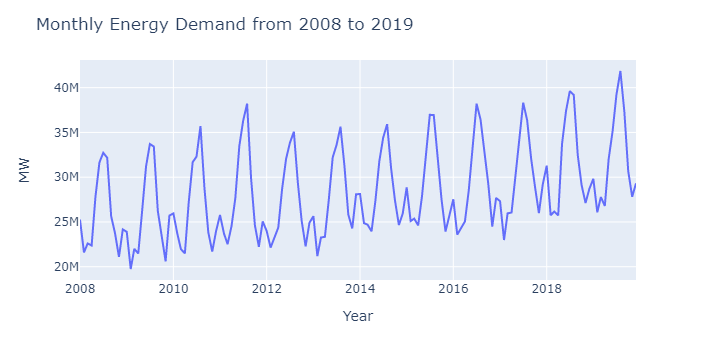

In [6]:
#Graph monthly ercot
fig = px.line(ercot_time_df_monthly_ercot, x = ercot_time_df_monthly_ercot.index, 
              y = ercot_time_df_monthly_ercot['ercot'],)
fig.update_layout(
    yaxis_title = "MW", 
    xaxis_title = "Year",
    legend_title = "", 
    title = "Monthly Energy Demand from 2008 to 2019"
)
fig.show()

In this visual we have the engergy demand by month across all the years for the entire ERCOT grid. We can more easily see the seasonal trends now:
- Highest demand in the summer with a peaks in August
- Lowest demand in the spring from Feb - April and November in the fall
- Winter has the next highest peaks in demand
- Winter peaks are about 75% of the summer load, occuring typically in January

Let's decompose this series to further extract seasonality and trend components:

In [7]:
ercot_time_df_monthly_ercot

ercot
hour_end                
2008-01-01  2.526168e+07
2008-02-01  2.159518e+07
2008-03-01  2.259868e+07
2008-04-01  2.236768e+07
2008-05-01  2.781585e+07
...                  ...
2019-08-01  4.186024e+07
2019-09-01  3.728983e+07
2019-10-01  3.069021e+07
2019-11-01  2.781448e+07
2019-12-01  2.931084e+07

[144 rows x 1 columns]

In [8]:
#Decompose the time series
decomposition = seasonal_decompose(ercot_time_df_monthly_ercot, model = 'additive')

# add the decomposition data
ercot_time_df_monthly_ercot["Trend"] = decomposition.trend
ercot_time_df_monthly_ercot["Seasonal"] = decomposition.seasonal
ercot_time_df_monthly_ercot["Residual"] = decomposition.resid

ercot_time_df_monthly_ercot.head(10)

ercot         Trend      Seasonal      Residual
hour_end                                                          
2008-01-01  2.526168e+07           NaN -1.095700e+06           NaN
2008-02-01  2.159518e+07           NaN -4.737585e+06           NaN
2008-03-01  2.259868e+07           NaN -4.060591e+06           NaN
2008-04-01  2.236768e+07           NaN -4.108302e+06           NaN
2008-05-01  2.781585e+07           NaN  3.215214e+05           NaN
2008-06-01  3.164277e+07           NaN  4.625968e+06           NaN
2008-07-01  3.272582e+07  2.584556e+07  7.455265e+06 -5.750047e+05
2008-08-01  3.217557e+07  2.571174e+07  7.885902e+06 -1.422077e+06
2008-09-01  2.563374e+07  2.560969e+07  2.103573e+06 -2.079514e+06
2008-10-01  2.374997e+07  2.554755e+07 -1.863667e+06  6.608752e+04

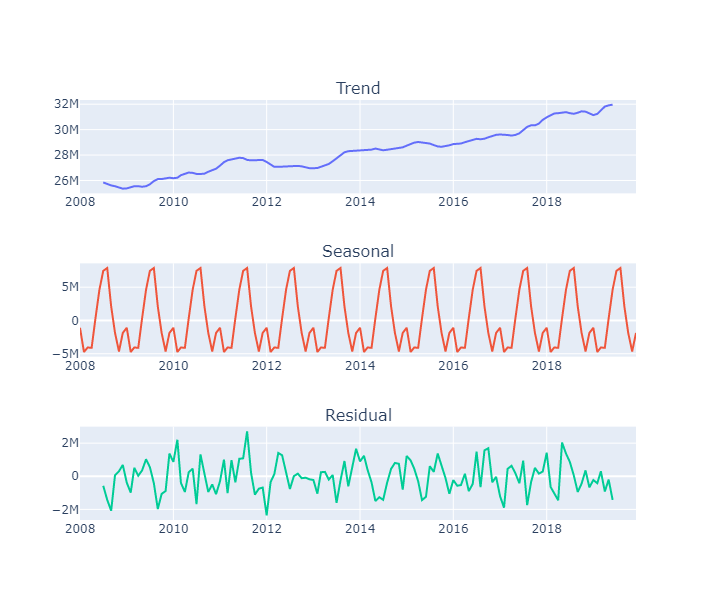

In [9]:
#Graph decomposition
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows = 3, cols = 1, subplot_titles = cols)

for i, col in enumerate(cols):
    fig.add_trace(go.Scatter(x = ercot_time_df_monthly_ercot.index, 
                             y = ercot_time_df_monthly_ercot[col]),
                  row = i+1, col = 1)

fig.update_layout(height = 600, width = 1000, showlegend = False)
fig.show()

In the first subplot we can see that the trend is clearly upward. It's interesting to see a dip and proceeding plateau in demand from July 2011 until October 2013. This this shows a million MW average decrease in energy demand for that time period. 

The seasonal plot clearly shows the seasonality we earlier explored, namely the highs in the summer and a smaller relative high in the winter.

The residual plot is actually fairly random and much of the seasonality is not evident. The variance does fluctuate a bit and next steps could be to account for this further. 

---
## Modeling
---
#### Transforming Data

Since we have some obvious seasonality and a positive trend in our data, we'll need to do some transformations on the data so that we can get a stationary series in order to use some standard forecasting techniques. First we'll difference by 12 so that we can remove the seasonality and store that in `seasonal_diff`:

In [10]:
#Transform data using seasonal differencing to model year-over-year change:
ercot_time_df_monthly_ercot['seasonal_diff'] = ercot_time_df_monthly_ercot['ercot'].diff(12)
ercot_time_df_monthly_ercot

ercot  Trend      Seasonal  Residual  seasonal_diff
hour_end                                                              
2008-01-01  2.526168e+07    NaN -1.095700e+06       NaN            NaN
2008-02-01  2.159518e+07    NaN -4.737585e+06       NaN            NaN
2008-03-01  2.259868e+07    NaN -4.060591e+06       NaN            NaN
2008-04-01  2.236768e+07    NaN -4.108302e+06       NaN            NaN
2008-05-01  2.781585e+07    NaN  3.215214e+05       NaN            NaN
...                  ...    ...           ...       ...            ...
2019-08-01  4.186024e+07    NaN  7.885902e+06       NaN     2672853.33
2019-09-01  3.728983e+07    NaN  2.103573e+06       NaN     4807394.95
2019-10-01  3.069021e+07    NaN -1.863667e+06       NaN     1560564.52
2019-11-01  2.781448e+07    NaN -4.654046e+06       NaN      700401.46
2019-12-01  2.931084e+07    NaN -1.872340e+06       NaN      602581.30

[144 rows x 5 columns]

Now let's take a look at the effect of our differencing:

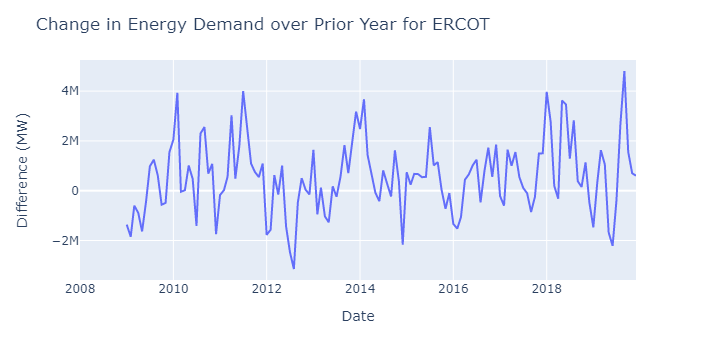

In [11]:
#Graph seasonal difference of 12
fig = px.line(ercot_time_df_monthly_ercot, 
              x = ercot_time_df_monthly_ercot.index, y = "seasonal_diff")

fig.update_layout(yaxis_title = "Difference (MW)", 
                  xaxis_title = "Date",
                  title = "Change in Energy Demand over Prior Year for ERCOT")
fig.show()

In the graph we can see that there are no remaining obvious cycles or seasonality patterns, as intended. There is, however, still a slight upwards trend, and our graphing of the trend earlier suggests it needs to be stabilized. 

In order to remove the upward trend, we can difference it again by a lag of 1.

In [12]:
#Transform data using seasonal differencing to model year-over-year change:
ercot_time_df_monthly_ercot['seasonal_diff'] = ercot_time_df_monthly_ercot['seasonal_diff'].diff(1)
ercot_time_df_monthly_ercot['seasonal_diff']

hour_end
2008-01-01           NaN
2008-02-01           NaN
2008-03-01           NaN
2008-04-01           NaN
2008-05-01           NaN
                 ...    
2019-08-01    3068741.34
2019-09-01    2134541.62
2019-10-01   -3246830.43
2019-11-01    -860163.06
2019-12-01     -97820.16
Freq: MS, Name: seasonal_diff, Length: 144, dtype: float64

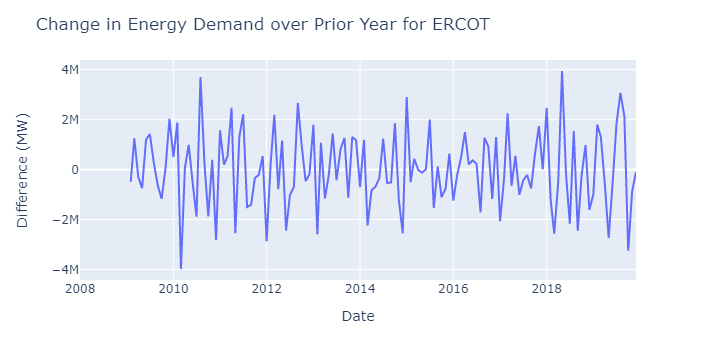

In [13]:
#Graph seasonal difference of 12
fig = px.line(ercot_time_df_monthly_ercot, 
              x = ercot_time_df_monthly_ercot.index, y = "seasonal_diff")

fig.update_layout(yaxis_title = "Difference (MW)", 
                  xaxis_title = "Date",
                  title = "Change in Energy Demand over Prior Year for ERCOT")
fig.show()

Nice, now we can see that there is no longer and upwards trend and still no seasonality. Because of this, we now have a reasonably stationary series and can proceed with modeling. 
    
Our forecast model could be based on predicting this differenced series instead of the original one.

*NOTE: A step in a later iteration of the model could be to take out the outliers to have a more constant variance.*

---
#### Train-Test Split

Let's use years up to 2018 as the training set and afterwards will be the testing set. We'll also need to drop the null values created by differencing during the transformation stage.

In [14]:
#Split sets and drop the null values introduced at differencing:
train = ercot_time_df_monthly_ercot.loc[ercot_time_df_monthly_ercot.index < "2018-01-01", \
                                           "seasonal_diff"].dropna()

test = ercot_time_df_monthly_ercot.loc[ercot_time_df_monthly_ercot.index >= "2018-01-01", \
                                       "seasonal_diff"]

Let's see how the splits turned out: 

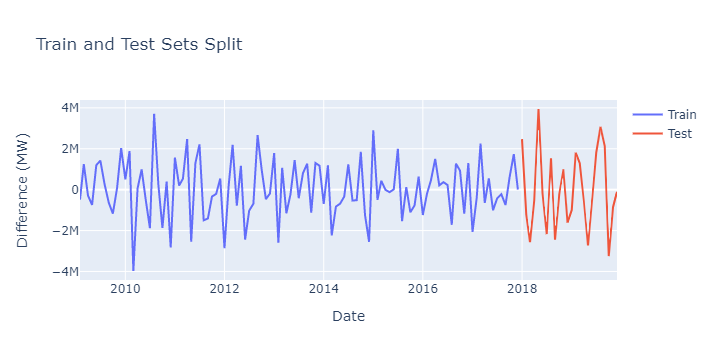

In [15]:
#Graph train and test
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train, mode = 'lines', name = "Train"))
fig.add_trace(go.Scatter(x = test.index, y = test, mode = 'lines', name = "Test"))

fig.update_layout(yaxis_title = "Difference (MW)", 
                  xaxis_title = "Date",
                  title = "Train and Test Sets Split")
fig.show()

The train and test splits look good, ending and beginning at 2018, respectively.

---
##### Simple Forecasting Model
Let's make a simple forecast with the mean over the train set since the differenced series is stationary. 

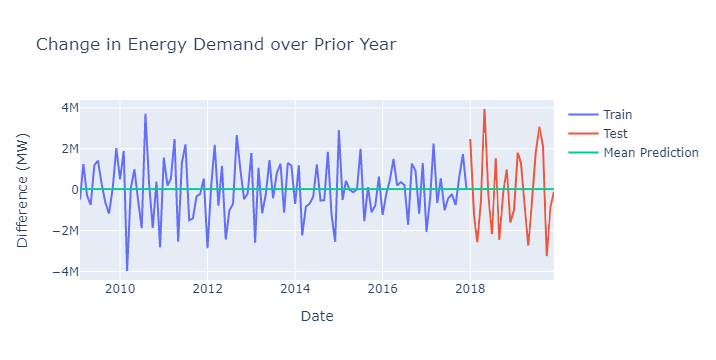

Train MAPE on the difference: 1.07%
Test MAPE on the difference: 1.03%


In [16]:
####################################
### Set up Train and test sets ### 
####################################
#Split sets and drop the null values introduced at differencing:
train = ercot_time_df_monthly_ercot.loc[ercot_time_df_monthly_ercot.index < "2018-01-01", \
                                           "seasonal_diff"].dropna()

test = ercot_time_df_monthly_ercot.loc[ercot_time_df_monthly_ercot.index >= "2018-01-01", \
                                       "seasonal_diff"]

######################################
############## Model #################
######################################
#Make all the predictions the average of the training set: 
predictions = pd.DataFrame({'train_avg': np.full(len(train) + len(test), train.mean())}, 
                        index = ercot_time_df_monthly_ercot['seasonal_diff'].dropna().index)

######################################
### Graph the Model's Performance ###
######################################
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train, mode = 'lines', name = "Train"))
fig.add_trace(go.Scatter(x = test.index, y = test, mode = 'lines', name = "Test"))
fig.add_trace(go.Scatter(x = predictions.index, y = predictions['train_avg'], mode = 'lines', 
                         name = "Mean Prediction"))

fig.update_layout(yaxis_title = "Difference (MW)", 
                  xaxis_title = "Date",
                  title = "Change in Energy Demand over Prior Year")
fig.show()

####################################
######### Score the Model ##########
####################################
train_mape = mean_absolute_percentage_error(train, predictions[:len(train)])
test_mape = mean_absolute_percentage_error(test, predictions[len(train):])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

In the scoring step we can use the mean absolute error (MAPE) to evaluate the model and see what percentage (on average) our prediction is off by the original value. This basic model shows the training set values varying by 1.07% and performing slightly better on the test set at 1.03%. Not bad for the roughest and most basic model after differencing the data. 

---
### Optimizing Parameters
Let's use autocorrelation and find the best values of p and q for our models. 

First let's take a look at how 1 month increment lags correlate to the most recent time data:

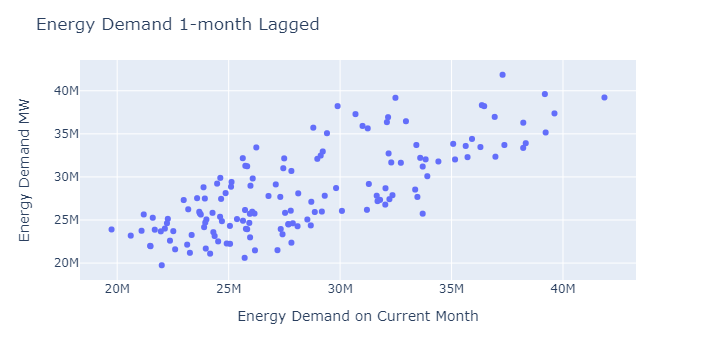

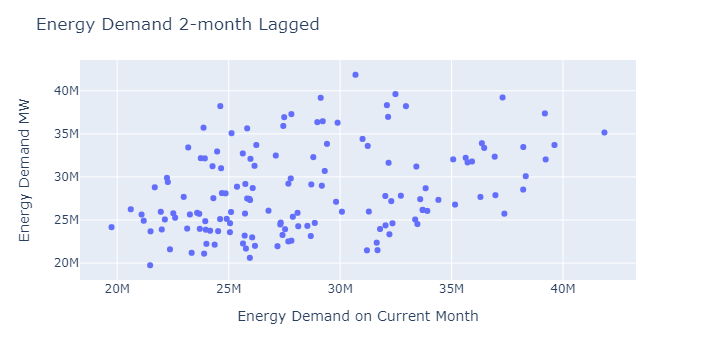

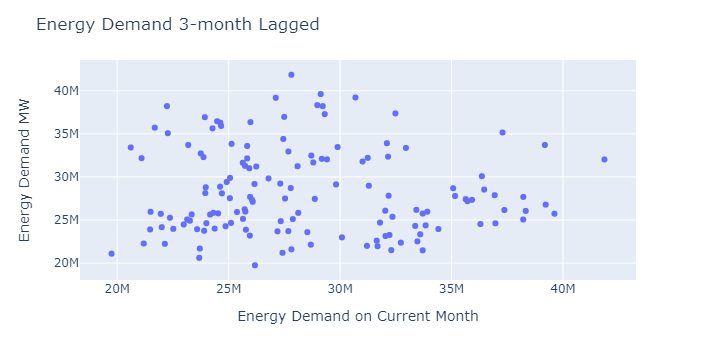

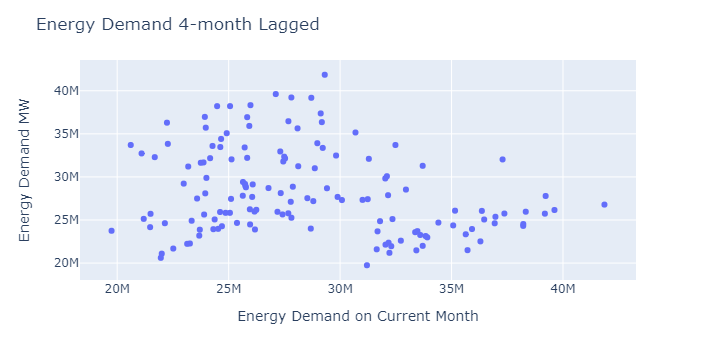

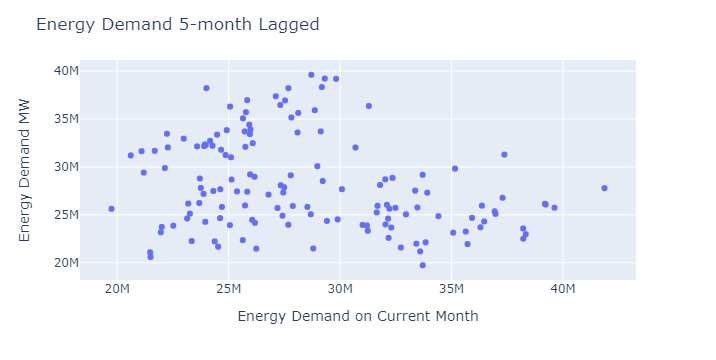

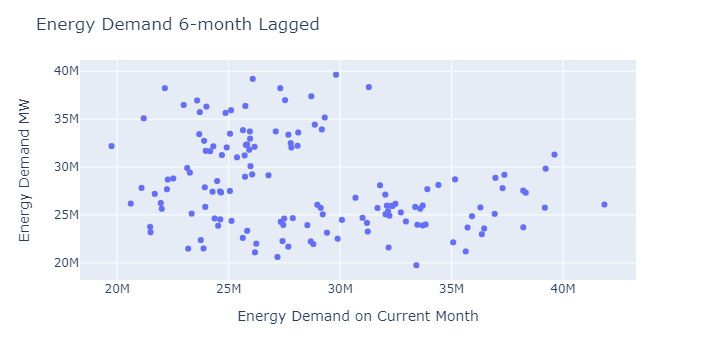

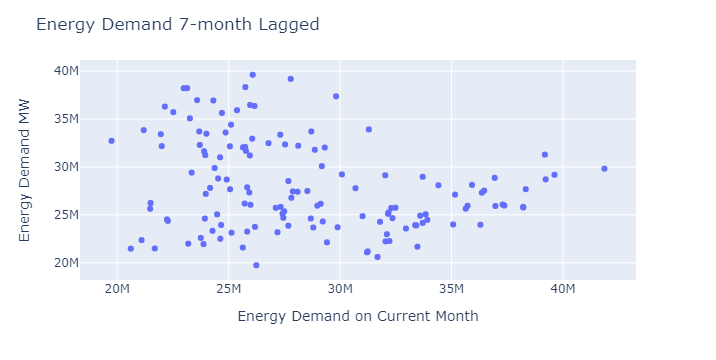

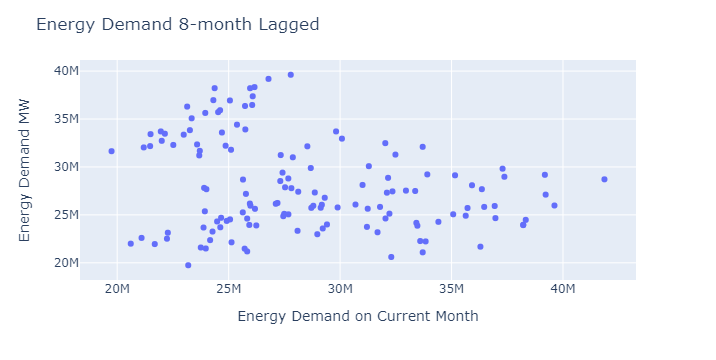

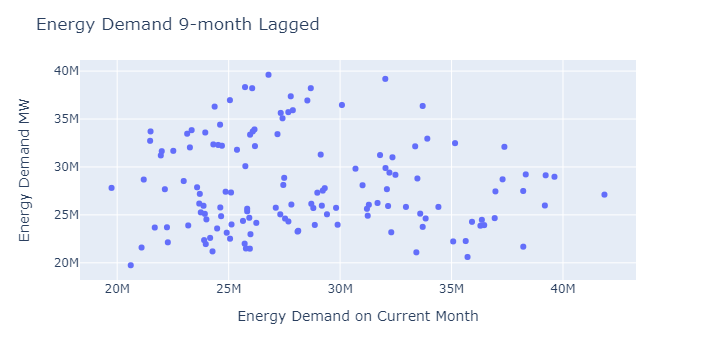

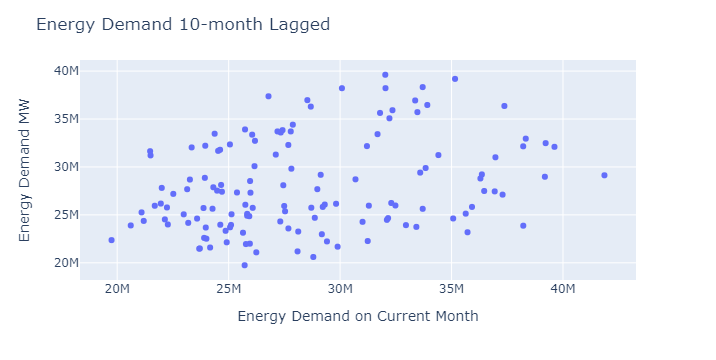

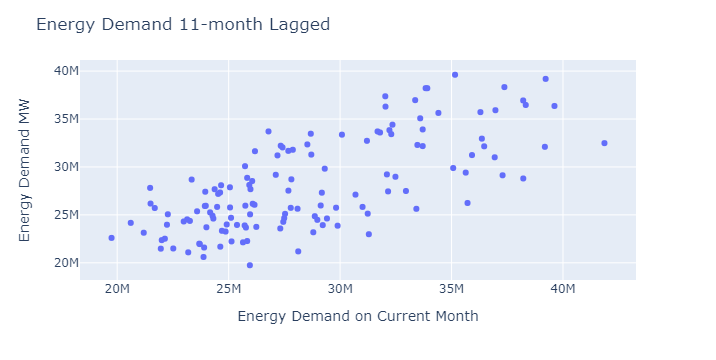

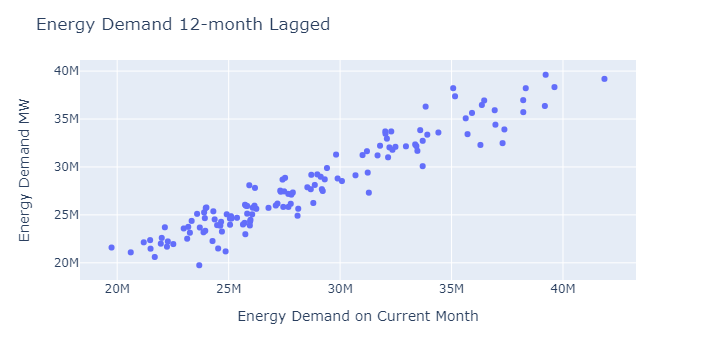

In [17]:
#Create Correlation plots from shifts 1-12
lags = list(range(1,13))

for i in lags: 
    fig = px.scatter(x = ercot_time_df_monthly_ercot["ercot"],
                     y = ercot_time_df_monthly_ercot["ercot"].shift(i))

    fig.update_layout(title = (f"Energy Demand {i}-month Lagged"),
                      xaxis_title = "Energy Demand on Current Month",
                      yaxis_title = (f"Energy Demand MW"))
    fig.show()

Here we can see that the energy demand of the 1, 11, and 12 months prior have positive correlations, with 12 being the strongest. This is understandable as we see the seasonality of the the data change on a yearly basis as energy demand seems to be heavily reliable on the season, mainly summer or winter. 

Let's also use the autocorrelation function plot (acf) to find the optimal q value for our model. First we'll plot the raw data:

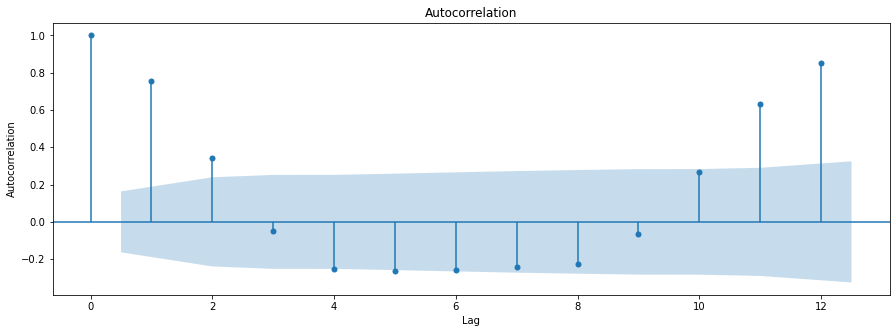

In [18]:
#Autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (15, 5))

# put the acf plot on the current axis
plot_acf(ercot_time_df_monthly_ercot["ercot"], lags = 12, ax = plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Now let's look at the same autocorrelation function plot on the differenced by 12 data: 

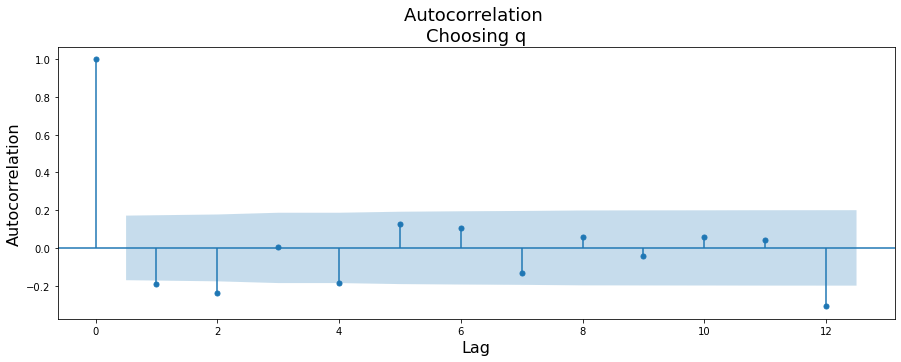

In [19]:
#Graph differenced data, dropping the missing values generated from differencing 
plt.figure(figsize = (15, 5))
plot_acf(ercot_time_df_monthly_ercot["seasonal_diff"].dropna(), lags = 12, ax = plt.gca())
plt.title('Autocorrelation \nChoosing q', fontsize = 18)
plt.xlabel('Lag', fontsize = 16)
plt.ylabel('Autocorrelation', fontsize = 16)
plt.show()

From both plots, but more so in the difference data plot, we can see that 1 and 12 month lags are the most significantly correlated and make good contenders for our q parameter. 

Next, let's take a look at the partial-autocorrelation function plot (pacf) in order to find the optimal p parameter for our model first on the original data: 

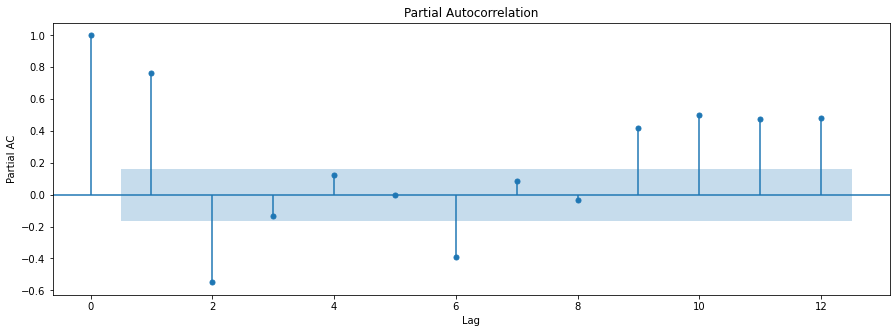

In [20]:
#Partial-autocorrelation plot (PACF)
plt.figure(figsize = (15, 5))
plot_pacf(ercot_time_df_monthly_ercot['ercot'], lags = 12, ax = plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

And again on the differenced data: 

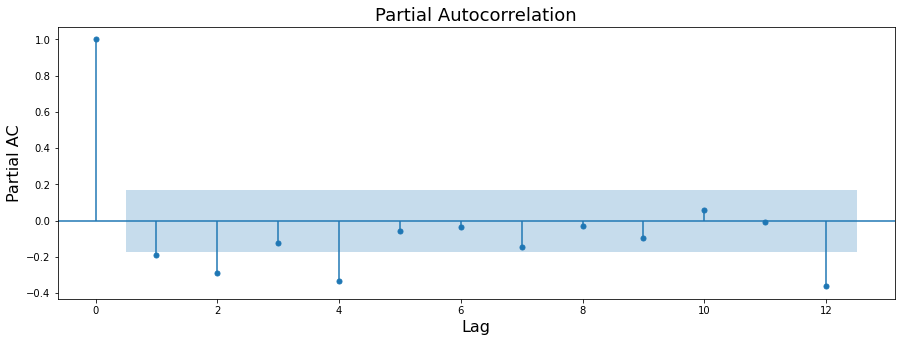

In [21]:
#Partial-autocorrelation plot (PACF)
plt.figure(figsize = (15, 5))
plot_pacf(ercot_time_df_monthly_ercot["seasonal_diff"].dropna(), lags = 12, ax = plt.gca())
plt.title('Partial Autocorrelation', fontsize = 18)
plt.xlabel('Lag', fontsize = 16)
plt.ylabel('Partial AC', fontsize = 16)
plt.show()

In the differenced plot (2nd) we see that 1, 2, 4, and 12 show a strong correlation in predicting values and could be possible candidates for p. 

---
### ARIMA Model 1
[Reference](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

Now lets put together a model using the original data. 

In [22]:
#Try without difference data

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=38521099.740059, expected=36360132.220000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=31961237.126831, expected=32099739.080000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27814026.176466, expected=28978191.220000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=25140295.322297, expected=25978967.050000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27785862.195725, expected=29180919.740000
predicted=29128247.328217, expected=31289442.350000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26025343.667824, expected=25748873.510000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27061348.875608, expected=26159888.740000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26245990.691636, expected=25734612.650000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=28835889.932591, expected=33705008.540000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=36639550.984813, expected=37371238.780000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=41581545.008879, expected=39617995.500000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=39343611.900841, expected=39187384.370000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=34014381.010323, expected=32482439.820000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=28008376.993350, expected=29129645.110000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=27015453.469699, expected=27114082.880000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=28247820.244208, expected=28708262.330000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=29645662.585051, expected=29819460.660000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26196043.232244, expected=26079371.700000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26160334.409861, expected=27785890.670000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=26773965.764931, expected=26787814.070000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=31744263.141502, expected=32027436.030000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=35495229.987611, expected=35157269.010000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=38467429.887567, expected=39222107.490000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=38963400.129311, expected=41860237.700000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=35389446.762738, expected=37289834.770000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=33372973.412639, expected=30690209.630000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=28394894.343996, expected=27814484.340000
predicted=28425041.611071, expected=29310843.630000


C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



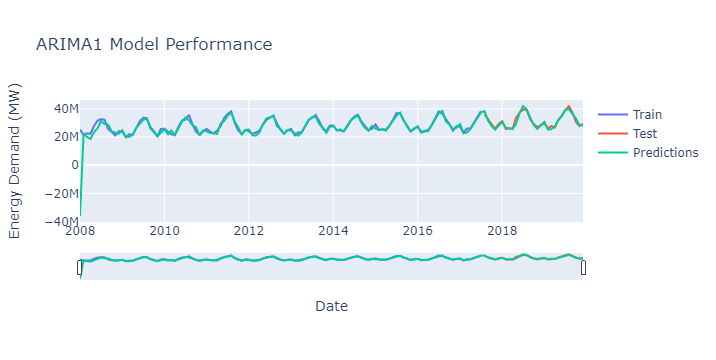

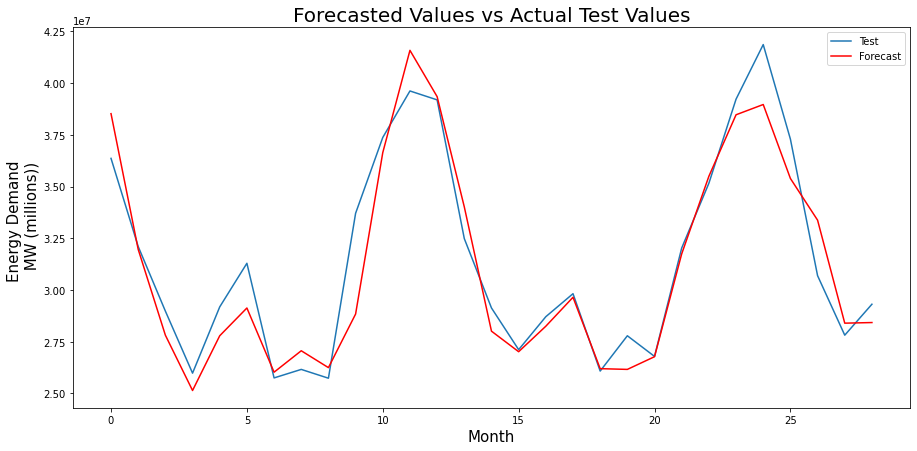

Train MAPE: 0.06%
Test MAPE: 0.03%
Wall time: 1min 44s


In [23]:
%%time
####################################
### Set up Train and test sets ### 
####################################
#Gather monthly data for the entire ERCOT region
monthly_ercot = ercot_time_df['ercot'].resample('MS').sum()

#Establish values
X = monthly_ercot.values

#Take 80% of the values 
split = int(len(X) * 0.80)
train, test = X[:split], X[split:]

####################################
history = [x for x in train]
forecasts = []

####################################
############ Run Model #############
####################################

#order = (p, d, q)
#Set d = 1 in order to difference for seasonality #Try 2? 
#Try 1 or 12 for q
#Try 1, 2, 4, or 12 for p

for t in range(len(test)):
    #Instantiate
    model = SARIMAX(history, order = (12, 0 , 12), trend = 'c')
    
    #Fit
    model_fit = model.fit(maxiter = 200)
    
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
#Predict
predictions = model_fit.predict(start = 0, end = len(train) + len(test) - 1)

####################################
### Plot the Model's Performance ###
####################################
#Graph the Predictions
time = monthly_ercot.index

fig = go.Figure()
fig.add_trace(go.Scatter(x = time, y = train, mode = 'lines', name = "Train"))
fig.add_trace(go.Scatter(x = time.shift(115), y = test, mode = 'lines', name = "Test"))
fig.add_trace(go.Scatter(x = time, y = predictions, mode = 'lines', name = "Predictions"))
fig.update_layout(yaxis_title = "Energy Demand (MW)", 
                  xaxis_title = "Date",
                  title = "ARIMA1 Model Performance")
fig.update_xaxes(rangeslider_visible = True)
fig.show()

#Plot forecast against actual test values
plt.figure(figsize = (15,7))
plt.plot(test, label = 'Test')
plt.plot(forecasts, label = 'Forecast', color = 'red')
plt.title('Forecasted Values vs Actual Test Values', fontsize = 20)
plt.ylabel('Energy Demand \n MW (millions))', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.legend()
plt.show()

####################################
######### Score the Model ##########
####################################
train_mape = mean_absolute_percentage_error(train, predictions[:115])
test_mape = mean_absolute_percentage_error(test, predictions[115:])

print(f"Train MAPE: {round(train_mape, 2)}%")
print(f"Test MAPE: {round(test_mape, 2)}%")

Looking at the graph of the modeling on the train set as well as predicting the test set we can see it the model is doing fairly well capturing the seasonality and trend. The MAPE score of 0.05% on the training data and .03% on the test set is pretty satisfying. 

In [24]:
#NOTE This was recorded outside of this notebook 
#and gathered simply by changing p, d, and q and running many times

#Create dataframe of model performance record 
model_performance = pd.DataFrame({'(1, 1 , 12)': [0.09, 0.05],
             '(2, 1 , 12)': [0.09, 0.05],
              '(4, 1 , 12)': [0.09, 0.05],
              '(12, 1 , 12)':  [0.06, 0.04],
              '(12, 1 , 1)': [0.07, 0.04],
              '(12, 2 , 12)': [0.08, 0.04],
              '(2, 2 , 12)': [0.09, 0.07],
              '(4, 2 , 12)': [0.08, 0.05],
              '(1, 2 , 12)': [0.09, 0.07],
              '(1, 0 , 12)': [0.07, 0.05], 
              '(2, 0 , 12)': [0.07, 0.05],
              '(4, 0, 12)': [0.07, 0.04], 
              '(12, 0, 12)': [.05, .03]}, index = ['Train MAPE', 'Test MAPE']).transpose()

#Sort by lowest MAPE score
model_performance.sort_values(by = ['Test MAPE'], inplace = True)

#Display dataframe 
model_performance

Train MAPE  Test MAPE
(12, 0, 12)         0.05       0.03
(12, 1 , 12)        0.06       0.04
(12, 1 , 1)         0.07       0.04
(12, 2 , 12)        0.08       0.04
(4, 0, 12)          0.07       0.04
(1, 1 , 12)         0.09       0.05
(2, 1 , 12)         0.09       0.05
(4, 1 , 12)         0.09       0.05
(4, 2 , 12)         0.08       0.05
(1, 0 , 12)         0.07       0.05
(2, 0 , 12)         0.07       0.05
(2, 2 , 12)         0.09       0.07
(1, 2 , 12)         0.09       0.07

In this chart we have the parameters for the ARIMA models in the format `(p, d, q)` denoted in the index and the train and test MAPE scores. The best model resulted in a train MAPE of 0.05% and a test MAPE of 0.03% with parameters (12, 0, 12).

The p and q parameters of 12 are not surprising as they represent the high correlation that occurs year to year (since this is monthly data a lag of 12 months = 1 year) but what was surprising is that the model performed best when there was no parameter accounting for differencing the data to account for seasonality and trend (the `d` parameter).

---
### ARIMA2

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\eph_4\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:             SARIMAX(12, 0, 12)   Log Likelihood               -1779.316
Date:                Mon, 27 Sep 2021   AIC                           3610.633
Time:                        06:29:43   BIC                           3682.001
Sample:                             0   HQIC                          3639.601
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.615e+06   2.71e-09   9.64e+14      0.000    2.62e+06    2.62e+06
ar.L1          0.1279      0.052      2.456      0.014       0.026       0.230
ar.L2         -0.0495      0.075     -0.655      0.512      -0.197       0.098
ar.L3         -0.0218      0.083     -0.261      0.794      -0.185       0.142
ar.L4          0.0348      0.079      0.439      0.661      -0.121       0.190
ar.L5         -0.0288      0.063     -0.454      0.650      -0.153       0.096
ar.L6         -0.0739      0.050     -1.471      0.141      -0.172       0.025
ar.L7          0.1097      0.056      1.958      0.050      -0.000       0.219
ar.L8         -0.0643      0.064     -1.004      0.315      -0.190       0.061
ar.L9         -0.0252      0.085     -0.298      0.765      -0.191       0.141
ar.L10         0.0425      0.075      0.570      0.569      -0.104       0.189
ar.L11        -0.0394      0.066     -0.600      0.549      -0.168       0.089
ar.L12         0.8953      0.057     15.655      0.000       0.783       1.007
ma.L1          0.4736      0.099      4.765      0.000       0.279       0.668
ma.L2          0.3363      0.108      3.101      0.002       0.124       0.549
ma.L3          0.1782      0.122      1.459      0.145      -0.061       0.418
ma.L4          0.0208      0.130      0.160      0.873      -0.234       0.276
ma.L5          0.2018      0.142      1.419      0.156      -0.077       0.481
ma.L6          0.2916      0.115      2.541      0.011       0.067       0.516
ma.L7         -0.1594      0.114     -1.395      0.163      -0.383       0.064
ma.L8         -0.0684      0.111     -0.616      0.538      -0.286       0.149
ma.L9         -0.1902      0.120     -1.584      0.113      -0.425       0.045
ma.L10        -0.0406      0.108     -0.375      0.708      -0.253       0.172
ma.L11         0.3276      0.118      2.765      0.006       0.095       0.560
ma.L12        -0.0205      0.126     -0.163      0.871      -0.267       0.226
sigma2      8.491e+11   1.73e-13   4.92e+24      0.000    8.49e+11    8.49e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.99   Prob(JB):                         0.41
Heteroskedasticity (H):               0.67   Skew:                             0.27
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.51e+39. Standard errors may be unstable.
"""

Are the above values the same as the predicted?: 
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


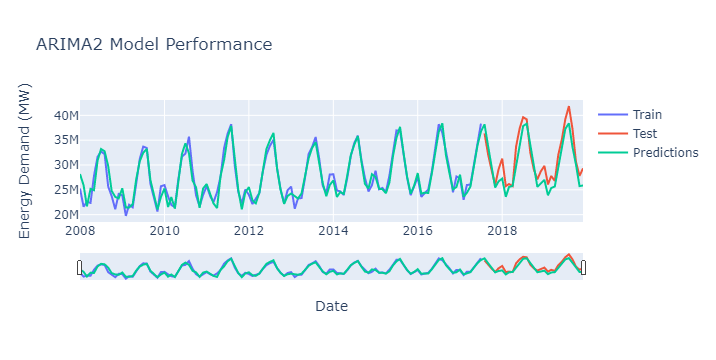

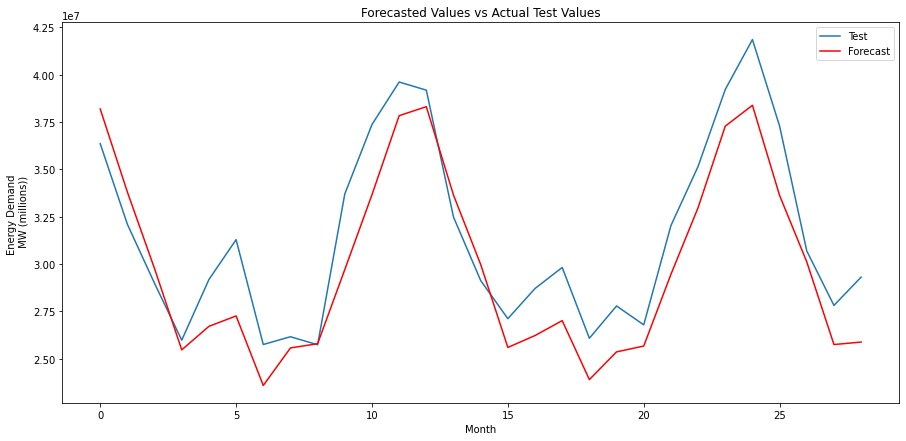

Train MAPE on the difference: 0.04%
Test MAPE on the difference: 0.06%
Wall time: 996 ms


In [25]:
%%time
#Set up Train and test sets 
#Gather monthly data for the entire ERCOT region
monthly_ercot = ercot_time_df['ercot'].resample('MS').sum()

#Establish values
X = monthly_ercot.values

#Take 80% of the values 
split = int(len(X) * 0.80)
train, test = X[:split], X[split:]
###################################
########### Run Model #############
###################################
#order = (p, d, q)
#Set d = 1 in order to difference for seasonality #Try 2? 
#Try 1 or 12 for q
#Try 1, 2, 4, or 12 for p

#Instantiate
model = SARIMAX(train, order = (12, 0, 12), trend = 'c') #Try without trend = 'c'

#Fit
model_fit = model.fit()

#Summarize
display(model_fit.summary())

predictions = model_fit.predict(start = 0, end = len(train) + len(test) - 1)

#Forecast
forecast = model_fit.forecast(steps = len(test)) #steps is how far out to forecast
values = predictions[len(train): len(train) + len(test)]

#Are the above values the same as the predicted?:
print(f'Are the above values the same as the predicted?: \n{forecast == values}')

####################################
### Plot the Model's Performance ###
####################################
#Graph the Predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x = time, y = train, mode = 'lines', name = "Train"))
fig.add_trace(go.Scatter(x = time[len(train):], y = test, mode = 'lines', name = "Test"))
fig.add_trace(go.Scatter(x = time, y = predictions, mode = 'lines', name = "Predictions"))
fig.update_layout(yaxis_title = "Energy Demand (MW)", 
                  xaxis_title = "Date",
                  title = "ARIMA2 Model Performance")
fig.update_xaxes(rangeslider_visible = True)
fig.show()

#Plot forecast against actual test values
plt.figure(figsize = (15,7))
plt.plot(test, label = 'Test')
plt.plot(forecast, label = 'Forecast', color = 'red')
plt.title('Forecasted Values vs Actual Test Values')
plt.ylabel('Energy Demand \n MW (millions))')
plt.xlabel('Month')
plt.legend()
plt.show()

####################################
######### Score the Model ##########
####################################
train_mape = mean_absolute_percentage_error(train, predictions[:115])
test_mape = mean_absolute_percentage_error(test, predictions[115:])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

This model also scores pretty well with a train MAPE of 0.04% and a test MAPE of 0.06%. Although this is slightly worse performance than the previous model and in the `Forecasted Values vs Actual Test Values` it does tend to under predict, the runtime was a mere second and had no convergence errors compared to the runtime of 1 min 39 seconds and multiple convergence errors on the previous model. 

---
### Prophet Model
Now let's do some forecasting with Facebook's Prophet forescasting package. This package works best with time series that have strong seasonal effects and several seasons of data - perfect for us!

[Reference](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

We'll need to gather and prepare the data so that Prophet can read the input properly. We'll make the column headers `ds` for the date by months and `y` for the object we want to predict, energy demand for the whole ERCOT grid.

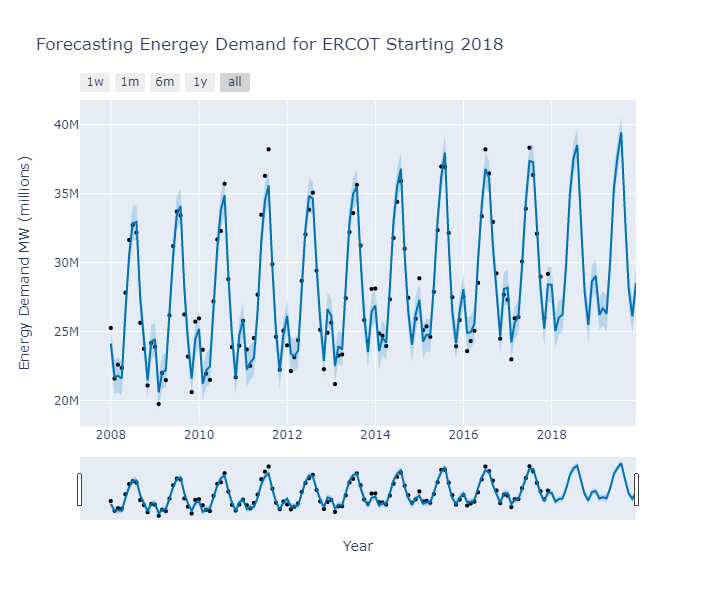

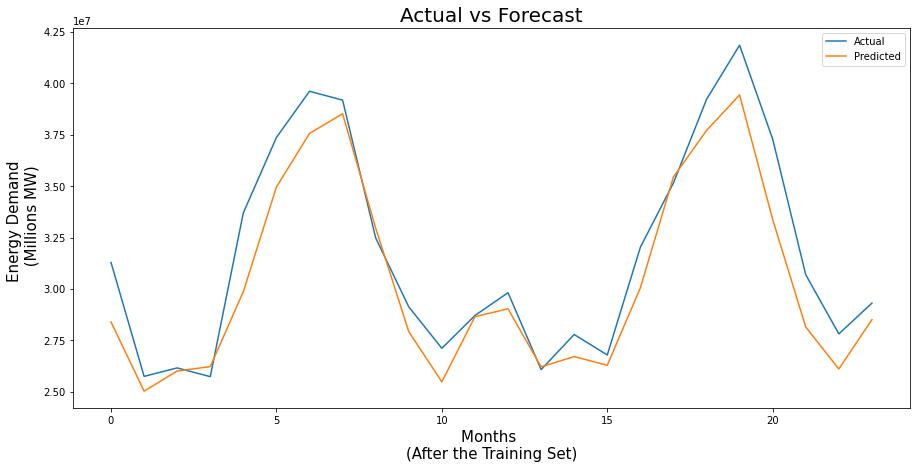

Check if prophet_train is in correct format:


ds             y
0 2008-01-01  2.526168e+07
1 2008-02-01  2.159518e+07
2 2008-03-01  2.259868e+07
3 2008-04-01  2.236768e+07
4 2008-05-01  2.781585e+07

Check if prophet_test is in correct format:


ds            y
0 2018-01-01  31289442.35
1 2018-02-01  25748873.51
2 2018-03-01  26159888.74
3 2018-04-01  25734612.65
4 2018-05-01  33705008.54

Check if predictions are in correct format:
Wall time: 1.13 s


ds          yhat    yhat_lower    yhat_upper
139 2019-08-01  3.944104e+07  3.824934e+07  4.061248e+07
140 2019-09-01  3.338195e+07  3.217930e+07  3.461129e+07
141 2019-10-01  2.814639e+07  2.688064e+07  2.936008e+07
142 2019-11-01  2.610771e+07  2.484389e+07  2.728125e+07
143 2019-12-01  2.850820e+07  2.731615e+07  2.975206e+07

In [31]:
%%time
######################
### Prepare Input ###
######################
#Gather monthly data for the entire ERCOT region
monthly_ercot = ercot_time_df['ercot'].resample('MS').sum()

#Create training set for dates prior to 2018
prophet_train = monthly_ercot.loc[monthly_ercot.index < "2018"].reset_index()
prophet_test = monthly_ercot.loc[monthly_ercot.index >= "2018"].reset_index()

#Rename columns to match Prophet's format to run the model
prophet_train.rename(columns = {"hour_end": "ds", "ercot": "y"}, inplace = True)
prophet_test.rename(columns = {"hour_end": "ds", "ercot": "y"}, inplace = True)

###############
#### Model ####
###############
#Instantiate model
model = Prophet(weekly_seasonality = True, daily_seasonality = True)

#Fit model
model.fit(prophet_train)

#Collect predictions
predictions = model.make_future_dataframe(periods = len(prophet_test), 
                                          freq = "MS", include_history = True)

#Forecast
forecast = model.predict(predictions)

#############################
### Visualize Performance ###
#############################
#Graph Forecast
fig = go.Figure()

#Predicted Demand
fig = plot_plotly(model, forecast) # returns a plotly Figure object

#Graph Details
fig.update_layout(yaxis_title = "Energy Demand MW (millions)", 
                  xaxis_title = "Year",
                  title = "Forecasting Energey Demand for ERCOT Starting 2018")
fig.show()

#Gather the forecasted values
y_pred_train = forecast['yhat'][:-24].values
y_pred_test = forecast['yhat'][-24:].values

#Gather true values
y_true_train = prophet_train['y'].values
y_true_test = prophet_test['y'].values

plt.figure(figsize = (15, 7))
plt.plot(y_true_test, label = 'Actual')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Actual vs Forecast', fontsize = '20')
plt.xlabel('Months \n(After the Training Set)', fontsize = 15)
plt.ylabel('Energy Demand \n (Millions MW)', fontsize = 15)
plt.legend()
plt.show()

#Check
print('Check if prophet_train is in correct format:')
display(prophet_train.head())
print('Check if prophet_test is in correct format:')
display(prophet_test.head())
print('Check if predictions are in correct format:')
predictions.head()
#Only display the year, predicted values, and lower and upper prediction boundaries
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Nice. We can see in the first graph `Forecasting Energey Demand for ERCOT Starting 2018`, the Prophet model's predictions in blue. It also includes the forecast from 2018 onwards and the train set indicated by the black points. The model is conservative overall and does tend to underpredict. It captured the seasonality and upwards trend really well and with ease for the user. We can now score the set and evaluate the performance.

In [32]:
#Score train set
train_mae = mean_absolute_error(y_true_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_true_train, y_pred_train)

#Score test set
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_true_test, y_pred_test)

prophet_score = pd.DataFrame({'MAE': [train_mae, test_mae], 
                              'MAPE': [train_mape, test_mape]}, index = ['Train', 'Test'])

display(prophet_score)

MAE      MAPE
Train  8.013915e+05  0.029181
Test   1.426634e+06  0.043416

We have a MAPE score of .03% on the training data and .04% on the test set, this looks great! And it's the best performance yet. The MAE shows us that the predictions have an average error of 0.8 MW on the train set and 1.4 MW on the test set (the forecast). Considering we are looking at 25 to 40 million MW a month, having this close of a margin isn't too bad. 